#TODO:

- Auto EDA
- Intentional EDA
- Simple feature engineering
- Outliers
- Cyclical features
- sns.distplot prediction vs actual


In [1]:
!pip install pandas_profiling
!pip install ydata-profiling
!pip install sweetviz
!pip install autoviz
!pip install dtale
!pip install boto3
!pip install evidently
!pip install --upgrade flask
!pip install --upgrade watchdog
!pip install PyQt6
!pip install hyperopt
!pip install mlflow

  Obtaining dependency information for visions[type_image_path]<0.7.7,>=0.7.5 from https://files.pythonhosted.org/packages/7c/bf/612b24e711ae25dea9af19b9304634b8949faa0b035fad47e8bcadf62f59/visions-0.7.6-py3-none-any.whl.metadata
  Using cached visions-0.7.6-py3-none-any.whl.metadata (11 kB)


Using cached visions-0.7.6-py3-none-any.whl (104 kB)
  Attempting uninstall: visions
    Found existing installation: visions 0.7.4
    Uninstalling visions-0.7.4:
      Successfully uninstalled visions-0.7.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires visions[type_image_path]==0.7.4, but you have visions 0.7.6 which is incompatible.


  Obtaining dependency information for Flask<2.3 from https://files.pythonhosted.org/packages/9f/1a/8b6d48162861009d1e017a9740431c78d860809773b66cac220a11aa3310/Flask-2.2.5-py3-none-any.whl.metadata
  Using cached Flask-2.2.5-py3-none-any.whl.metadata (3.9 kB)
Using cached Flask-2.2.5-py3-none-any.whl (101 kB)
  Attempting uninstall: Flask
    Found existing installation: Flask 3.0.3
    Uninstalling Flask-3.0.3:
      Successfully uninstalled Flask-3.0.3


  Obtaining dependency information for flask from https://files.pythonhosted.org/packages/61/80/ffe1da13ad9300f87c93af113edd0638c75138c42a0994becfacac078c06/flask-3.0.3-py3-none-any.whl.metadata
  Using cached flask-3.0.3-py3-none-any.whl.metadata (3.2 kB)
Using cached flask-3.0.3-py3-none-any.whl (101 kB)


  Attempting uninstall: flask
    Found existing installation: Flask 2.2.5
    Uninstalling Flask-2.2.5:
      Successfully uninstalled Flask-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dtale 3.13.1 requires Flask<2.3; python_version >= "3.7", but you have flask 3.0.3 which is incompatible.


In [2]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from ydata_profiling import ProfileReport
import sweetviz as sv
import dtale
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, average_precision_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
import mlflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
import pickle
from flask import Flask, request, jsonify
import requests
from evidently.report import Report
from evidently.metrics import DatasetSummaryMetric
from evidently.metric_preset import DataDriftPreset, ClassificationPreset
from evidently import ColumnMapping

In [3]:
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root=artifacts_local
MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

mlflow.set_experiment("flight_delay_local_test")

client = MlflowClient(MLFLOW_TRACKING_URI)

# Definitions

Arrival delay equals the difference of the actual arrival time minus the scheduled arrival time.  A flight is considered on-time when it arrives less than 15 minutes after its published arrival time.



# Data Ingestion

In [4]:
july_data_raw = pd.read_csv("../data/july_2023.csv")
august_data_raw = pd.read_csv("../data/august_2023.csv")
september_data_raw = pd.read_csv("../data/september_2023.csv")
weather_data = pd.read_csv("../data/weather_meteo_by_airport.csv")
op_unique_carrier_lookup = pd.read_csv("../data/L_UNIQUE_CARRIERS.csv")

In [5]:
july_data_raw["FL_DATE"] = pd.to_datetime(july_data_raw["FL_DATE"])
august_data_raw["FL_DATE"] = pd.to_datetime(august_data_raw["FL_DATE"])
september_data_raw["FL_DATE"] = pd.to_datetime(september_data_raw["FL_DATE"])
weather_data["time"] = pd.to_datetime(weather_data["time"])

/var/folders/1x/_t_zsqxx3_bdlb0k32ryftbm0000gn/T/ipykernel_76984/1429820222.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/1x/_t_zsqxx3_bdlb0k32ryftbm0000gn/T/ipykernel_76984/1429820222.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/1x/_t_zsqxx3_bdlb0k32ryftbm0000gn/T/ipykernel_76984/1429820222.py:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [6]:
weather_data["join_date"] = weather_data["time"] - timedelta(days=1)

In [7]:
july_data_raw = (
    july_data_raw
    .merge(op_unique_carrier_lookup, left_on = ["OP_UNIQUE_CARRIER"], right_on=["Code"])
#     .merge(weather_data, left_on=["FL_DATE", "ORIGIN"], right_on=["join_date", "airport_id"])
#     .drop(["time", "join_date", "airport_id"], axis=1)
    .rename(columns = {
        "Description":"AIRLINE",
#         "tavg":"ORIGIN_TAVG",
#         "tmin":"ORIGIN_TMIN",
#         "tmax":"ORIGIN_TMAX",
#         "prcp":"ORIGIN_PRCP",
#         "snow":"ORIGIN_SNOW",
#         "wdir":"ORIGIN_WDIR",
#         "wspd":"ORIGIN_WSPD",
#         "pres":"ORIGIN_PRES",
        
    })
#     .merge(weather_data, left_on=["FL_DATE", "DEST"], right_on=["join_date", "airport_id"])
#     .drop(["time", "join_date", "airport_id"], axis=1)
#     .rename(columns = {
#         "tavg":"DEST_TAVG",
#         "tmin":"DEST_TMIN",
#         "tmax":"DEST_TMAX",
#         "prcp":"DEST_PRCP",
#         "snow":"DEST_SNOW",
#         "wdir":"DEST_WDIR",
#         "wspd":"DEST_WSPD",
#         "pres":"DEST_PRES",
        
#     })
)

In [8]:
august_data_raw = (
    august_data_raw
    .merge(op_unique_carrier_lookup, left_on = ["OP_UNIQUE_CARRIER"], right_on=["Code"])
#     .merge(weather_data, left_on=["FL_DATE", "ORIGIN"], right_on=["join_date", "airport_id"])
#     .drop(["time", "join_date", "airport_id"], axis=1)
    .rename(columns = {
        "Description":"AIRLINE",
#         "tavg":"ORIGIN_TAVG",
#         "tmin":"ORIGIN_TMIN",
#         "tmax":"ORIGIN_TMAX",
#         "prcp":"ORIGIN_PRCP",
#         "snow":"ORIGIN_SNOW",
#         "wdir":"ORIGIN_WDIR",
#         "wspd":"ORIGIN_WSPD",
#         "pres":"ORIGIN_PRES",
        
    })
#     .merge(weather_data, left_on=["FL_DATE", "DEST"], right_on=["join_date", "airport_id"])
#     .drop(["time", "join_date", "airport_id"], axis=1)
#     .rename(columns = {
#         "tavg":"DEST_TAVG",
#         "tmin":"DEST_TMIN",
#         "tmax":"DEST_TMAX",
#         "prcp":"DEST_PRCP",
#         "snow":"DEST_SNOW",
#         "wdir":"DEST_WDIR",
#         "wspd":"DEST_WSPD",
#         "pres":"DEST_PRES",
        
#     })
)

In [9]:
september_data_raw = (
    september_data_raw
    .merge(op_unique_carrier_lookup, left_on = ["OP_UNIQUE_CARRIER"], right_on=["Code"])
#     .merge(weather_data, left_on=["FL_DATE", "ORIGIN"], right_on=["join_date", "airport_id"])
#     .drop(["time", "join_date", "airport_id"], axis=1)
    .rename(columns = {
        "Description":"AIRLINE",
#         "tavg":"ORIGIN_TAVG",
#         "tmin":"ORIGIN_TMIN",
#         "tmax":"ORIGIN_TMAX",
#         "prcp":"ORIGIN_PRCP",
#         "snow":"ORIGIN_SNOW",
#         "wdir":"ORIGIN_WDIR",
#         "wspd":"ORIGIN_WSPD",
#         "pres":"ORIGIN_PRES",
        
    })
#     .merge(weather_data, left_on=["FL_DATE", "DEST"], right_on=["join_date", "airport_id"])
#     .drop(["time", "join_date", "airport_id"], axis=1)
#     .rename(columns = {
#         "tavg":"DEST_TAVG",
#         "tmin":"DEST_TMIN",
#         "tmax":"DEST_TMAX",
#         "prcp":"DEST_PRCP",
#         "snow":"DEST_SNOW",
#         "wdir":"DEST_WDIR",
#         "wspd":"DEST_WSPD",
#         "pres":"DEST_PRES",
        
#     })
)

# Data Preprocessing

We need to avoid data leakage by limiting the features we use to those that will be available to us before flight departure.

Some new feature ideas:

- Average delay for this route in the past month
- Airline's on-time performance over the past week
- Airport congestion statistics based on historical data
- Weather forecast data for departure and arrival airports
- Historical performance of the route
- Historical perforance of the airline
- Historical performance of the aircraft
- Historical performance of airport
- Analyze performance from city market to city market



In [10]:
cols_to_keep = [
    "DAY_OF_MONTH",
    "DAY_OF_WEEK",
    "AIRLINE",
    "ORIGIN",
    "DEST",
    "CRS_DEP_TIME",
    "CRS_ARR_TIME",
    "CRS_ELAPSED_TIME",
    "DISTANCE",
    "ARR_DELAY",
    "ARR_DEL15"
]

In [11]:
july_data = july_data_raw[cols_to_keep].dropna(subset=["ARR_DELAY", "ARR_DEL15"])

In [12]:
august_data = august_data_raw[cols_to_keep].dropna(subset=["ARR_DELAY", "ARR_DEL15"])

In [13]:
september_data = september_data_raw[cols_to_keep].dropna(subset=["ARR_DELAY", "ARR_DEL15"])

In [14]:
profile = ProfileReport(july_data, title='Flight Data Auto EDA')
profile.to_file('./reports/auto_eda_ydata.html')

/Users/adelhassen/anaconda3/lib/python3.11/site-packages/ydata_profiling/profile_report.py:363: UserWarning:

Try running command: 'pip install --upgrade Pillow' to avoid ValueError



Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
report = sv.analyze(july_data, target_feat="ARR_DEL15")
report.show_html('./reports/auto_eda_sv.html')

                                             |      | [  0%]   00:00 -> (? left)

Report ./reports/auto_eda_sv.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [17]:
dtale.show(july_data)

In [18]:
july_data.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,ARR_DELAY,ARR_DEL15
count,585058.000000,585058.000000,585058.000000,585058.000000,585058.000000,585058.000000,585058.000000,585058.000000
mean,16.223844,4.034650,1333.655135,1471.944647,145.616392,846.286377,16.641825,0.285579
std,8.880154,2.072493,503.713292,537.722409,73.367314,610.844774,72.101824,0.451690
min,1.000000,1.000000,1.000000,1.000000,23.000000,31.000000,-86.000000,0.000000
25%,9.000000,2.000000,905.000000,1045.000000,91.000000,402.000000,-13.000000,0.000000
50%,16.000000,4.000000,1322.000000,1503.000000,128.000000,683.000000,-2.000000,0.000000
75%,24.000000,6.000000,1747.000000,1922.000000,175.000000,1076.000000,20.000000,1.000000
max,31.000000,7.000000,2359.000000,2359.000000,671.000000,5095.000000,3337.000000,1.000000


In [19]:
july_data.select_dtypes(include="object").describe()

,AIRLINE,ORIGIN,DEST
count,585058,585058,585058
unique,15,336,336
top,Southwest Airlines Co.,ATL,ATL
freq,124840,29406,29363


In [20]:
%matplotlib inline

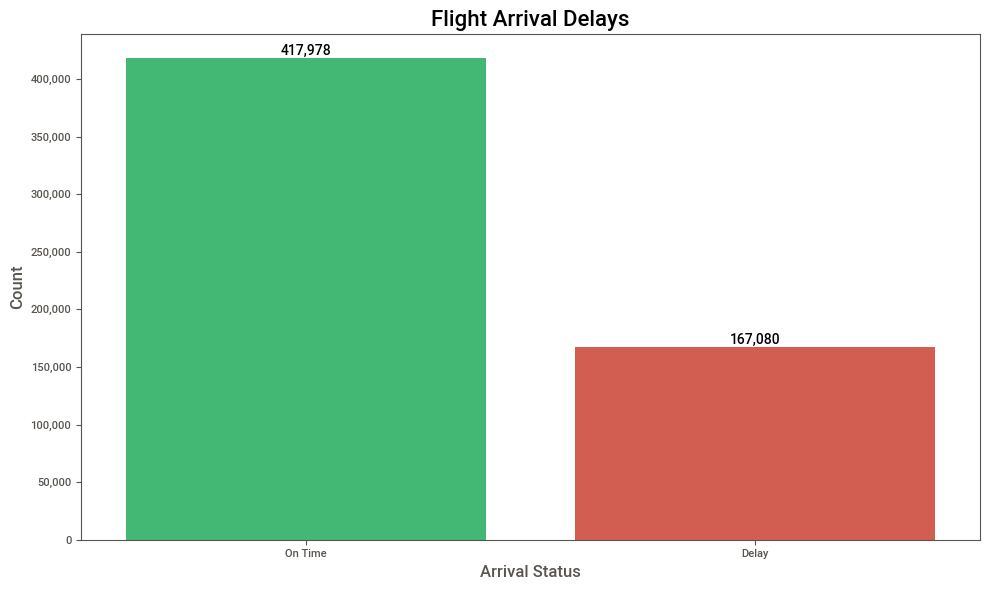

In [21]:
# Assuming you have your data in a DataFrame called df
counts = july_data['ARR_DEL15'].value_counts().sort_index()

# Create a new DataFrame for plotting
plot_df = pd.DataFrame({'Status': ['On Time', 'Delay'], 'Count': counts.values})

# Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Status', y='Count', data=plot_df, hue='Status', palette=['#2ecc71', '#e74c3c'])

# Customize the chart
plt.title('Flight Arrival Delays', fontsize=16)
plt.xlabel('Arrival Status', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add value labels on top of each bar
for i, v in enumerate(plot_df['Count']):
    ax.text(i, v, f'{v:,}', ha='center', va='bottom')

# Add commas to y-axis labels for better readability
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

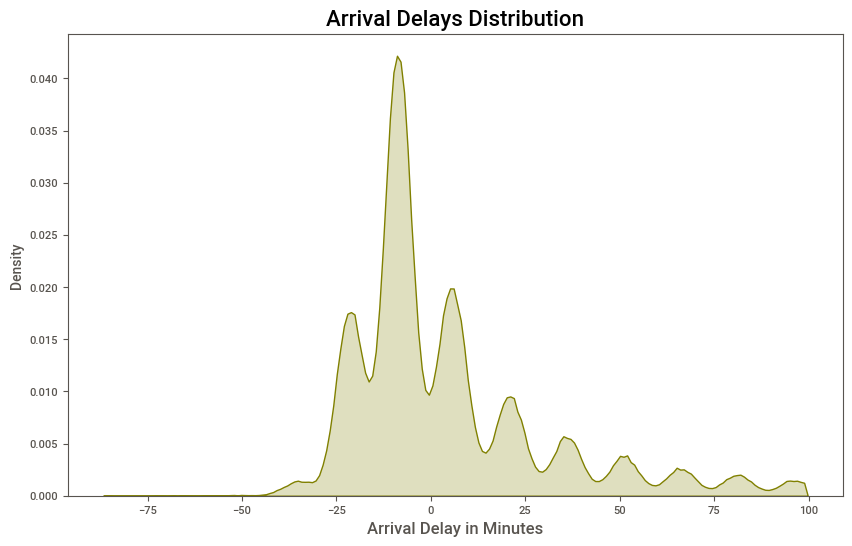

In [22]:
# However, in order to be smoothed, we need to define a bandwidth
# which is a parameter that controls the smoothness of the density plot.
# bw_method defines that
plt.figure(figsize=(10, 6))

ax = sns.kdeplot(july_data.query("ARR_DELAY < 100")['ARR_DELAY'], fill=True, color="olive", bw_method=0.01)

plt.title('Arrival Delays Distribution', fontsize=16)
plt.xlabel('Arrival Delay in Minutes', fontsize=12)

plt.show()

In [23]:
pcnt_delayed_per_airline = (
    july_data
    .groupby("AIRLINE", as_index=False)
    .agg(
        PCNT_OF_DELAYS = ("ARR_DEL15", "mean"),
    )
    .sort_values("PCNT_OF_DELAYS", ascending=False)
)

# pcnt_delayed_per_airline.assign(PCNT_OF_DELAYS = pcnt_delayed_per_airline.PCNT_OF_DELAYS*100)

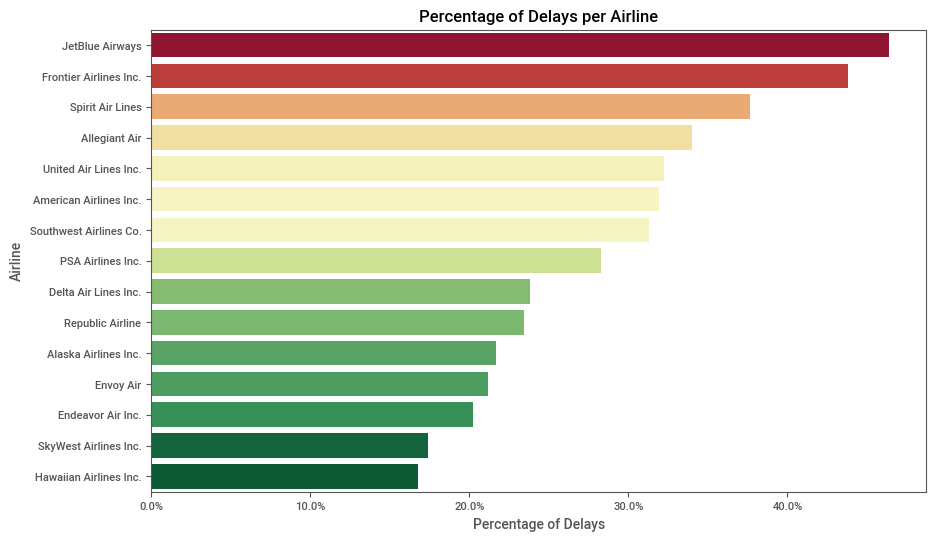

In [24]:
# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='PCNT_OF_DELAYS', y='AIRLINE', data=pcnt_delayed_per_airline, hue="PCNT_OF_DELAYS", palette='RdYlGn_r', legend=False)

# Add title and labels
plt.title('Percentage of Delays per Airline')
plt.xlabel('Percentage of Delays')
plt.ylabel('Airline')

# Format the x-axis to include percentage sign
ax = plt.gca()
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))

# Show the plot
plt.show()

In [25]:
pcnt_delayed_per_route = (
    july_data
    .assign(ROUTE = july_data.ORIGIN + "_" + july_data.DEST)
    .groupby(["ROUTE"], as_index=False)
    .agg(
        PCNT_OF_DELAYS = ("ARR_DEL15", "mean"),
        NUM_OF_FLIGHTS = ("ARR_DEL15", "size")
    )
    .sort_values("PCNT_OF_DELAYS", ascending=False)
    .query("NUM_OF_FLIGHTS > 30")
    .reset_index(drop=True)
    .head(10)
)

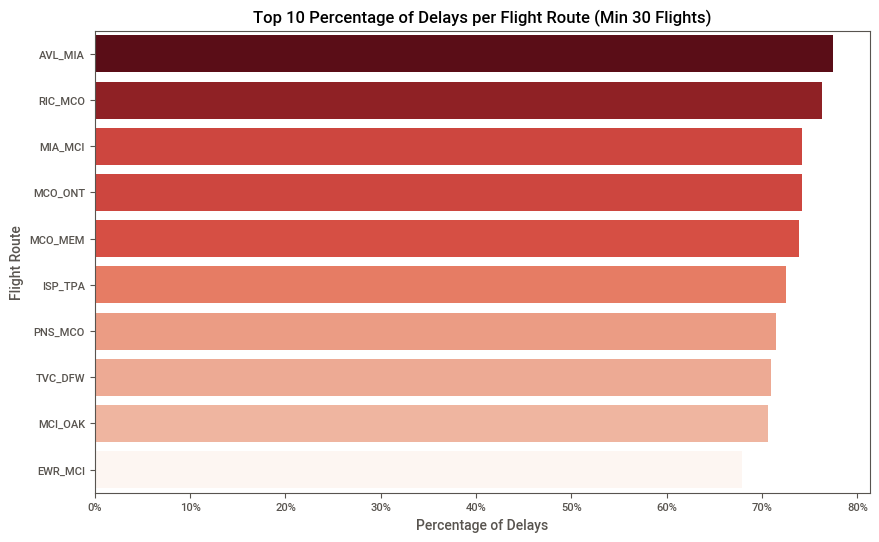

In [26]:
# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='PCNT_OF_DELAYS', y='ROUTE', data=pcnt_delayed_per_route, hue="PCNT_OF_DELAYS", palette='Reds', legend=False)

# Add title and labels
plt.title('Top 10 Percentage of Delays per Flight Route (Min 30 Flights)')
plt.xlabel('Percentage of Delays')
plt.ylabel('Flight Route')

# Format the x-axis to include percentage sign
ax = plt.gca()
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))

# Show the plot
plt.show()

In [27]:
pcnt_delayed_per_doy = (
    july_data
    .groupby(["DAY_OF_WEEK"], as_index=False)
    .agg(
        PCNT_OF_DELAYS = ("ARR_DEL15", "mean"),
        NUM_OF_FLIGHTS = ("ARR_DEL15", "size")
    )
    .sort_values("DAY_OF_WEEK", ascending=True)
    .reset_index(drop=True)
)

In [28]:
(
    pcnt_delayed_per_doy["DAY_OF_WEEK"]
    .replace(
        {1:"Monday", 2:"Tuesday", 3:"Wednesday", 4:"Thursday", 
         5:"Friday", 6:"Saturday", 7:"Sunday"
        }
        , inplace=True
    )
)

2024-07-26 16:48:44,355 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-26 16:48:44,360 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


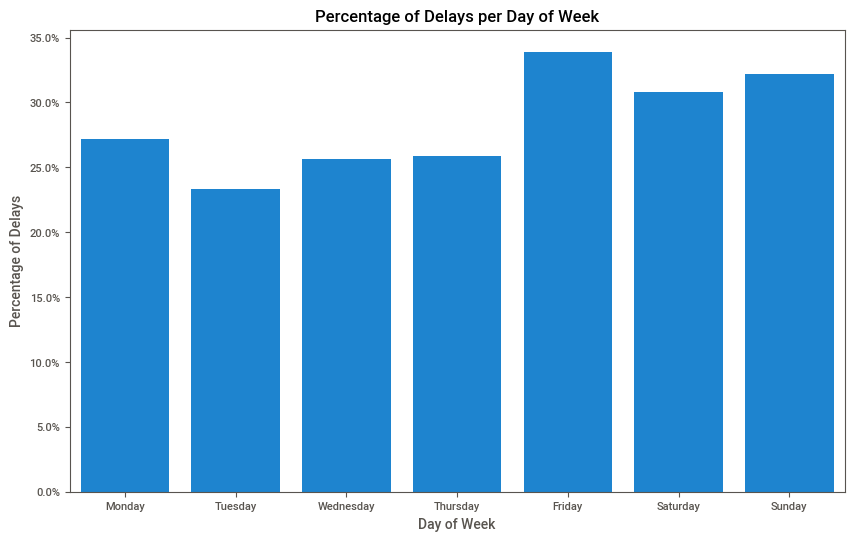

In [29]:
# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='DAY_OF_WEEK', y='PCNT_OF_DELAYS', data=pcnt_delayed_per_doy, legend=False)

# Add title and labels
plt.title('Percentage of Delays per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Percentage of Delays')

# Format the x-axis to include percentage sign
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

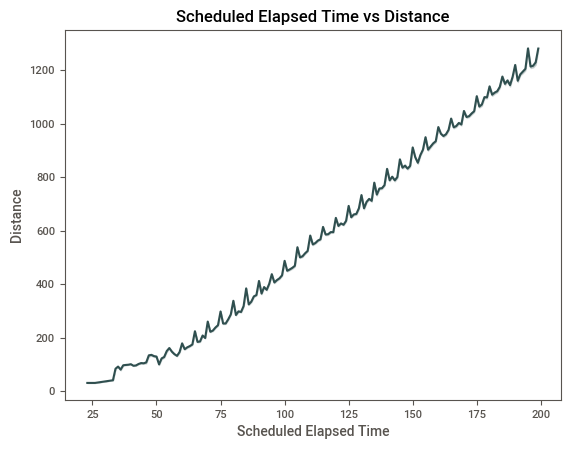

In [30]:
# Highly correlated so we need to drop one of them
ax = sns.lineplot(data=july_data.query("ARR_DELAY < 100 and CRS_ELAPSED_TIME < 200"), x="CRS_ELAPSED_TIME", y="DISTANCE", color="darkslategrey")

# Add title and labels
plt.title('Scheduled Elapsed Time vs Distance')
plt.xlabel('Scheduled Elapsed Time')
plt.ylabel('Distance')

plt.show()

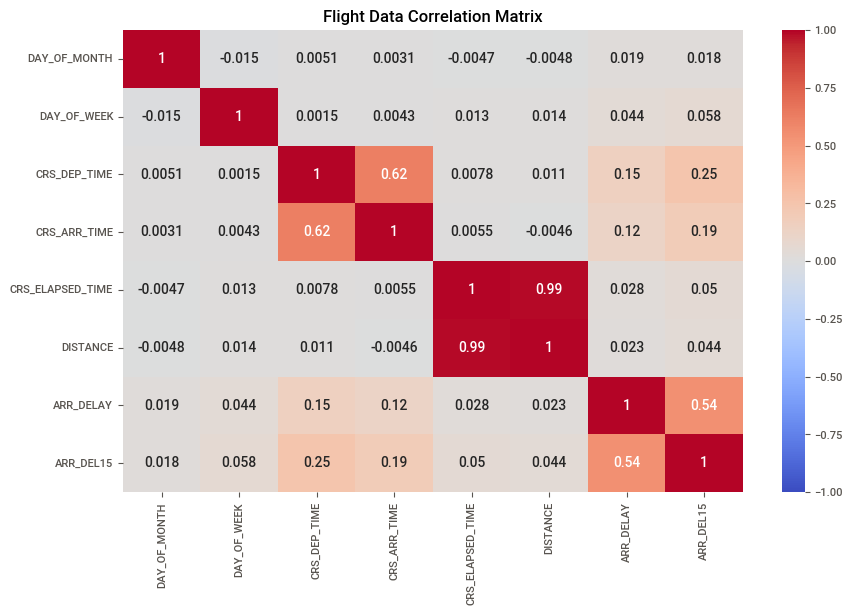

In [31]:
# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(july_data.select_dtypes(include=["int64", "float64"]).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Flight Data Correlation Matrix')
plt.show()

# Feature Engineering

In [32]:
X_train = july_data.drop(["ARR_DEL15"], axis=1).copy()
y_train = july_data['ARR_DEL15'].values

X_val = august_data.drop(["ARR_DEL15"], axis=1).copy()
y_val = august_data['ARR_DEL15'].values

X_test = september_data.drop(["ARR_DEL15"], axis=1).copy()
y_test = september_data['ARR_DEL15'].values

In [33]:
X_train_copy = X_train.drop(["DISTANCE", "ARR_DELAY"], axis=1).copy()
X_train_copy["DAY_OF_WEEK"] = (
    X_train["DAY_OF_WEEK"]
    .replace(
        {1:"Monday", 2:"Tuesday", 3:"Wednesday", 4:"Thursday", 
         5:"Friday", 6:"Saturday", 7:"Sunday"
        }
    )
)

X_val_copy = X_val.drop(["DISTANCE", "ARR_DELAY"], axis=1).copy()
X_val_copy["DAY_OF_WEEK"] = (
    X_val["DAY_OF_WEEK"]
    .replace(
        {1:"Monday", 2:"Tuesday", 3:"Wednesday", 4:"Thursday", 
         5:"Friday", 6:"Saturday", 7:"Sunday"
        }
    )
)

X_test_copy = X_test.drop(["DISTANCE", "ARR_DELAY"], axis=1).copy()
X_test_copy["DAY_OF_WEEK"] = (
    X_test["DAY_OF_WEEK"]
    .replace(
        {1:"Monday", 2:"Tuesday", 3:"Wednesday", 4:"Thursday", 
         5:"Friday", 6:"Saturday", 7:"Sunday"
        }
    )
)

In [34]:
def time_to_minutes(int_time):
    # Convert the integer to string to handle different lengths
    str_time = str(int_time).zfill(4)  # Ensure it's at least 4 digits long
    # Extract hours and minutes
    hours = int(str_time[:-2])  # All but last two characters
    minutes = int(str_time[-2:])  # Last two characters
    
    # Convert hour and minutes to total minutes of the day
    total_minutes = hours * 60 + minutes
    
    return total_minutes

In [35]:
X_train["CRS_DEP_TIME_MINUTES"] = X_train["CRS_DEP_TIME"].apply(time_to_minutes)
X_train["CRS_ARR_TIME_MINUTES"] = X_train["CRS_ARR_TIME"].apply(time_to_minutes)

X_val["CRS_DEP_TIME_MINUTES"] = X_val["CRS_DEP_TIME"].apply(time_to_minutes)
X_val["CRS_ARR_TIME_MINUTES"] = X_val["CRS_ARR_TIME"].apply(time_to_minutes)

X_test["CRS_DEP_TIME_MINUTES"] = X_test["CRS_DEP_TIME"].apply(time_to_minutes)
X_test["CRS_ARR_TIME_MINUTES"] = X_test["CRS_ARR_TIME"].apply(time_to_minutes)

In [36]:
# Define function to create cyclical features
def create_cyclical_features(df: pd.DataFrame, column: str, max_val: int):
    
    df[f'{column}_SIN'] = np.sin(2 * np.pi * df[column] / max_val)
    df[f'{column}_COS'] = np.cos(2 * np.pi * df[column] / max_val)
    
    return df

In [37]:
X_train = create_cyclical_features(X_train, "DAY_OF_MONTH", X_train["DAY_OF_MONTH"].max())
X_train = create_cyclical_features(X_train, "DAY_OF_WEEK", X_train["DAY_OF_WEEK"].max())
X_train = create_cyclical_features(X_train, "CRS_DEP_TIME_MINUTES", 1440)
X_train = create_cyclical_features(X_train, "CRS_ARR_TIME_MINUTES", 1440)

X_val = create_cyclical_features(X_val, "DAY_OF_MONTH", X_val["DAY_OF_MONTH"].max())
X_val = create_cyclical_features(X_val, "DAY_OF_WEEK", X_val["DAY_OF_WEEK"].max())
X_val = create_cyclical_features(X_val, "CRS_DEP_TIME_MINUTES", 1440)
X_val = create_cyclical_features(X_val, "CRS_ARR_TIME_MINUTES", 1440)

X_test = create_cyclical_features(X_test, "DAY_OF_MONTH", X_val["DAY_OF_MONTH"].max())
X_test = create_cyclical_features(X_test, "DAY_OF_WEEK", X_val["DAY_OF_WEEK"].max())
X_test = create_cyclical_features(X_test, "CRS_DEP_TIME_MINUTES", 1440)
X_test = create_cyclical_features(X_test, "CRS_ARR_TIME_MINUTES", 1440)

In [38]:
# Drop distance because that would be hard for someone to find
# Drop ARR_DELAY because we will use ARR_DEL15 to create a categorical ML problem
X_train.drop(["DISTANCE", "ARR_DELAY", "DAY_OF_MONTH", "DAY_OF_WEEK", "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_DEP_TIME_MINUTES", "CRS_ARR_TIME_MINUTES"], axis=1, inplace=True)
X_val.drop(["DISTANCE", "ARR_DELAY", "DAY_OF_MONTH", "DAY_OF_WEEK", "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_DEP_TIME_MINUTES", "CRS_ARR_TIME_MINUTES"], axis=1, inplace=True)
X_test.drop(["DISTANCE", "ARR_DELAY", "DAY_OF_MONTH", "DAY_OF_WEEK", "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_DEP_TIME_MINUTES", "CRS_ARR_TIME_MINUTES"], axis=1, inplace=True)

In [39]:
X_train_flask = X_train.copy()

In [40]:
categorical = ["AIRLINE", "ORIGIN", "DEST"]
numerical = ['CRS_ELAPSED_TIME', 'DAY_OF_MONTH_SIN', 'DAY_OF_MONTH_COS', 'DAY_OF_WEEK_SIN', 'DAY_OF_WEEK_COS',
             'CRS_DEP_TIME_MINUTES_SIN', 'CRS_DEP_TIME_MINUTES_COS', 'CRS_ARR_TIME_MINUTES_SIN',
             'CRS_ARR_TIME_MINUTES_COS'
            ]

dv = DictVectorizer()

train_dicts = X_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = X_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dicts = X_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [41]:
def fit_base_models(model_name, X_train, X_val, y_train, y_val, dv):
    with mlflow.start_run():
        
        if not os.path.exists("../models"):
            os.makedirs("models")
        
        mlflow.set_tag("model", type(model_name()).__name__)
        mlflow.set_tag("purpose", "train models")
        
        model = model_name(random_state=42).fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        
        mlflow.log_params(model.get_params())
        
        mlflow.log_metric("accuracy", accuracy_score(y_val, y_pred))
        mlflow.log_metric("precision", precision_score(y_val, y_pred))
        mlflow.log_metric("recall", recall_score(y_val, y_pred))
        mlflow.log_metric("f1", f1_score(y_val, y_pred))
        mlflow.log_metric("roc_auc", roc_auc_score(y_val, y_pred_proba))
        mlflow.log_metric("auprc", average_precision_score(y_val, y_pred_proba))
        
        mlflow.sklearn.log_model(model, artifact_path="models")
        
        with open("../models/preprocessor.b", "wb") as f_out:
            pickle.dump(dv, f_out)
        mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")
        
        print(f"Training for {type(model_name()).__name__} complete!")
        
    

In [ ]:
fit_base_models(LogisticRegression, X_train, X_val, y_train, y_val, dv)
fit_base_models(xgb.XGBClassifier, X_train, X_val, y_train, y_val, dv)

# Hyperparameter Tuning

In [42]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

def tune_xgboost(train, valid, y_val, eval_metric, dv):
    
    def objective(params):
        with mlflow.start_run():
            mlflow.set_tag("model", "XGBClassifier")
            mlflow.set_tag("purpose", "Tune XGBClassifier")
            mlflow.set_tag("eval_metric", eval_metric)

            mlflow.log_params(params)

            booster = xgb.train(
                params=params,
                dtrain=train,
                num_boost_round=5,
                evals=[(valid, 'validation')],
                early_stopping_rounds=5
            )

            y_pred = booster.predict(valid)
            y_pred_class = (y_pred >= 0.5).astype(int)

            if eval_metric == "logloss":
                metric = log_loss(y_val, y_pred)
            # since value is positive and we want to minimize, make it negative
            elif eval_metric == "auc":
                metric = -roc_auc_score(y_val, y_pred)
            # since value is positive and we want to minimize, make it negative
            elif eval_metric == "aucpr":
                metric = -average_precision_score(y_val, y_pred) 


            mlflow.log_metric("accuracy", accuracy_score(y_val, y_pred_class))
            mlflow.log_metric("precision", precision_score(y_val, y_pred_class))
            mlflow.log_metric("recall", recall_score(y_val, y_pred_class))
            mlflow.log_metric("f1", f1_score(y_val, y_pred_class))
            mlflow.log_metric("roc_auc", roc_auc_score(y_val, y_pred))
            mlflow.log_metric("auprc", average_precision_score(y_val, y_pred))

            mlflow.xgboost.log_model(booster, artifact_path="models")

            with open("../models/preprocessor.b", "wb") as f_out:
                pickle.dump(dv, f_out)
            mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

        return {'loss': metric, 'status': STATUS_OK}
    
    search_space = {
        'max_depth': scope.int(hp.quniform('max_depth', 4, 10, 1)),
        'learning_rate': hp.loguniform('learning_rate', -3, 0),
        'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
        'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
        'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
        'objective': 'binary:logistic',
        'eval_metric': eval_metric,
        'seed': 42
    }
    
    
    
    best_result = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=5,
        trials=Trials()
    )
    
    return

In [ ]:
tune_xgboost(train, valid, y_val, "logloss")
tune_xgboost(train, valid, y_val, "auc")
tune_xgboost(train, valid, y_val, "aucpr")

# Register Models

In [43]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)
test = xgb.DMatrix(X_test, label=y_test)

In [44]:
def train_and_log_model(train, valid, test, dv, params):
    with mlflow.start_run():
        
        mlflow.set_tag("model", "XGBClassifier")
        mlflow.set_tag("purpose", "Compare best models")
        mlflow.log_params(params)
        
        booster = xgb.train(
                params=params,
                dtrain=train,
                num_boost_round=5,
                evals=[(valid, 'validation')],
                early_stopping_rounds=5
            )


        # Evaluate and log model on the validation set
        y_pred_val = booster.predict(valid)
        y_pred_val_class = (y_pred_val >= 0.5).astype(int)
        
        mlflow.log_metric("accuracy", accuracy_score(y_val, y_pred_val_class))
        mlflow.log_metric("precision", precision_score(y_val, y_pred_val_class))
        mlflow.log_metric("recall", recall_score(y_val, y_pred_val_class))
        mlflow.log_metric("f1", f1_score(y_val, y_pred_val_class))
        mlflow.log_metric("roc_auc", roc_auc_score(y_val, y_pred_val))
        mlflow.log_metric("auprc", average_precision_score(y_val, y_pred_val))
        
        # Evaluate and log model on test set
        y_pred_test = booster.predict(test)
        y_pred_test_class = (y_pred_test >= 0.5).astype(int)
        
        mlflow.log_metric("test_accuracy", accuracy_score(y_test, y_pred_test_class))
        mlflow.log_metric("test_precision", precision_score(y_test, y_pred_test_class))
        mlflow.log_metric("test_recall", recall_score(y_test, y_pred_test_class))
        mlflow.log_metric("test_f1", f1_score(y_test, y_pred_test_class))
        mlflow.log_metric("test_roc_auc", roc_auc_score(y_test, y_pred_test))
        mlflow.log_metric("test_auprc", average_precision_score(y_test, y_pred_test))
        
        mlflow.xgboost.log_model(booster, artifact_path="models")

        with open("../models/preprocessor.b", "wb") as f_out:
            pickle.dump(dv, f_out)
        mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")


In [45]:
mlflow.set_experiment("xgboost_best_models_test")

<Experiment: artifact_location='/Users/adelhassen/data_science/flight_delays/artifacts_local/2', creation_time=1721699404035, experiment_id='2', last_update_time=1721699404035, lifecycle_stage='active', name='xgboost_best_models_test', tags={}>

In [46]:
def run_register_model(train, valid, test, dv, top_n: 5):

    client = MlflowClient()

    # Retrieve the top_n model runs and log the models
    experiment = client.get_experiment_by_name("flight_delay_local_test")
    runs = client.search_runs(
        experiment_ids=experiment.experiment_id,
        filter_string="tags.purpose='Tune XGBClassifier'",
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=top_n,
        order_by=["metrics.auprc DESC"]
    )
    for run in runs:
        train_and_log_model(train, valid, test, dv, params=run.data.params)

    # Select the model with the lowest test RMSE
    experiment = client.get_experiment_by_name("xgboost_best_models_test")
    best_run = client.search_runs(
        experiment_ids=experiment.experiment_id,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=top_n,
        order_by=["metrics.test_auprc DESC"]
    )[0]

    # Register the best model
    run_id = best_run.info.run_id
    model_uri = f"runs:/{run_id}/model"
    mlflow.register_model(model_uri, name="xgboost_best_model_test")

In [ ]:
run_register_model(train, valid, test, dv, top_n=5)

In [47]:
registered_model = client.search_registered_models(filter_string="name='xgboost_best_model_test'")
registered_model_run_id = registered_model[0].latest_versions[0].run_id

logged_model = f'runs:/{registered_model_run_id}/models'

# Load model as a XGBoost
model_to_deploy = mlflow.xgboost.load_model(logged_model)

path_to_dv = client.download_artifacts(run_id=registered_model_run_id, path='preprocessor/preprocessor.b')
with open(path_to_dv, 'rb') as f_out:
    dv = pickle.load(f_out)


# Deploy on Web App

In [48]:
registered_model = client.search_registered_models(filter_string="name='xgboost_best_model_test'")
registered_model_run_id = registered_model[0].latest_versions[0].run_id

logged_model = f'runs:/{registered_model_run_id}/models'

# Load model as a XGBoost
model_to_deploy = mlflow.xgboost.load_model(logged_model)

path_to_dv = client.download_artifacts(run_id=registered_model_run_id, path='preprocessor/preprocessor.b')
with open(path_to_dv, 'rb') as f_out:
    dv = pickle.load(f_out)

In [49]:
def predict(features):
    X_transformed = dv.transform(features)
    X = xgb.DMatrix(X_transformed)
    pred = model_to_deploy.predict(X)[0]
    pred_class = (pred >= 0.5).astype(int)
    
    if pred_class:
        return_string = f"Delayed! There is a {pred:.2%} chance your flight will be delayed."
    else:
        return_string = f"On time! There is a {pred:.2%} chance your flight will be delayed."
    return return_string

In [50]:
app = Flask('flight-delay-prediction')

@app.route('/predict', methods=['POST'])
def predict_endpoint():
    flight_features = request.get_json()
    pred = predict(flight_features)

    result = {
        'delay': pred
    }

    return jsonify(result)

In [ ]:
# Run in a py script, jupyter notebook and flask conflict
# app.run(debug=True, host='0.0.0.0', port=9696)

In [51]:
X_train_flask.loc[0].to_dict()

{'AIRLINE': 'Endeavor Air Inc.',
 'ORIGIN': 'AUS',
 'DEST': 'RDU',
 'CRS_ELAPSED_TIME': 185.0,
 'DAY_OF_MONTH_SIN': 0.20129852008866006,
 'DAY_OF_MONTH_COS': 0.9795299412524945,
 'DAY_OF_WEEK_SIN': -0.7818314824680299,
 'DAY_OF_WEEK_COS': 0.6234898018587334,
 'CRS_DEP_TIME_MINUTES_SIN': 0.4733196671848435,
 'CRS_DEP_TIME_MINUTES_COS': -0.8808907382053855,
 'CRS_ARR_TIME_MINUTES_SIN': -0.5446390350150271,
 'CRS_ARR_TIME_MINUTES_COS': -0.838670567945424}

In [52]:
predict(X_train_flask.loc[129794].to_dict())

'Delayed! There is a 78.88% chance your flight will be delayed.'

# Monitoring

In [54]:
registered_model = client.search_registered_models(filter_string="name='xgboost_best_model_test'")
registered_model_run_id = registered_model[0].latest_versions[0].run_id

logged_model = f'runs:/{registered_model_run_id}/models'

# Load model as a XGBoost
model_to_deploy = mlflow.xgboost.load_model(logged_model)

In [56]:
preds_train = model_to_deploy.predict(train)
preds_train2 = 1 - preds_train 
preds_class_train = (preds_train >= 0.5).astype(int)

preds_val = model_to_deploy.predict(valid)
preds_val2 = 1 - preds_val
preds_class_val = (preds_val >= 0.5).astype(int)

X_train_copy["Arrival Delay"] = np.where(y_train == 0, "On Time", "Delay")
X_val_copy["Arrival Delay"] = np.where(y_val == 0, "On Time", "Delay")

X_train_copy["Delay"] = preds_train
X_val_copy["Delay"] = preds_val
X_train_copy["On Time"] = preds_train2
X_val_copy["On Time"] = preds_val2

In [58]:
# categorical = ["AIRLINE", "ORIGIN", "DEST"]
# numerical = ['CRS_ELAPSED_TIME', 'DAY_OF_MONTH_SIN', 'DAY_OF_MONTH_COS', 'DAY_OF_WEEK_SIN', 'DAY_OF_WEEK_COS',
#              'CRS_DEP_TIME_MINUTES_SIN', 'CRS_DEP_TIME_MINUTES_COS', 'CRS_ARR_TIME_MINUTES_SIN',
#              'CRS_ARR_TIME_MINUTES_COS'
#             ]


categorical = ["AIRLINE", "ORIGIN", "DEST", "DAY_OF_MONTH", "DAY_OF_WEEK"]
numerical = ["CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME"]

column_mapping = ColumnMapping()

column_mapping.target = 'Arrival Delay'
column_mapping.prediction = ['Delay', 'On Time']
column_mapping.pos_label = 'Delay'
column_mapping.numerical_features = numerical
column_mapping.categorical_features = categorical

classification_performance_report = Report(metrics=[
    ClassificationPreset(),
    DataDriftPreset(),
])

classification_performance_report.run(reference_data=X_train_copy, current_data=X_val_copy, column_mapping=column_mapping)

classification_performance_report.save_html("../reports/Monitoring_Report.html")

# Appendix


In [ ]:
# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_val)
print("Decision Tree Classifier Accuracy:", accuracy_score(y_val, dt_predictions))
print("Decision Tree Classification Report:\n", classification_report(y_val, dt_predictions))

In [ ]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=10)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_val)
print("Random Forest Classifier Accuracy:", accuracy_score(y_val, rf_predictions))
print("Random Forest Classification Report:\n", classification_report(y_val, rf_predictions))

In [ ]:
# XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_classifier.fit(X_train, y_train)
xgb_predictions = xgb_classifier.predict(X_val)
print("XGBoost Classifier Accuracy:", accuracy_score(y_val, xgb_predictions))
print("XGBoost Classification Report:\n", classification_report(y_val, xgb_predictions))

In [ ]:
roc_auc_score(y_val, xgb_predictions)

In [ ]:
def transition_model(client):
    
    
    # Retrieve the new model with the lowest test RMSE
    experiment = client.get_experiment_by_name("xgboost_best_models_test")
    best_run = client.search_runs(
        experiment_ids=experiment.experiment_id,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=1,
        order_by=["metrics.test_auprc ASC"]
    )[0]

    run_id = best_run.info.run_id
    model_uri = f"runs:/{run_id}/model"
    
    registered_model = client.search_registered_models(filter_string="name='xgboost_best_model_test'")
    production_run_id = [model.run_id for model in registered_model[0].latest_versions if model.current_stage == 'Production']

    if production_run_id:
        # Get AUPRC for production model and new model
        auprc_production = client.get_run(production_run_id[0]).data.metrics['test_auprc']
        
        auprc_new_model = client.get_run(run_id).data.metrics['test_auprc']
        
        if auprc_new_model > auprc_production:
            client.transition_model_version_stage(
                name='flight-delay-classifier',
                version=model_version,
                stage=new_stage,
                archive_existing_versions=False
            )
            
    

In [ ]:
def create_time_chunks(df: pd.DataFrame, time_column: str, new_column: str):
    # Define conditions and choices for np.select
    conditions = [
        df[time_column].between(500, 1159),
        df[time_column].between(1200, 1659),
        df[time_column].between(1700, 2059)
    ]
    choices = ['morning', 'afternoon', 'evening']

    # Apply np.select
    df[new_column] = np.select(conditions, choices, default='night')
    return df

X_train = create_time_chunks(X_train, "CRS_DEP_TIME", "CRS_DEP_BLOCK")
X_train = create_time_chunks(X_train, "CRS_ARR_TIME", "CRS_ARR_BLOCK")